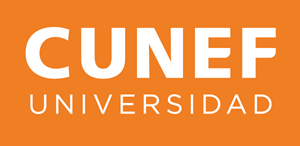
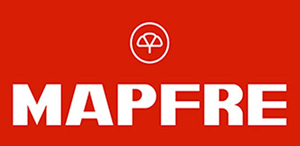

# Master en Data Science - Trabajo Final de Máster

# Modelado Predictivo
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
### DataSet: *IBM - Telco Customer Churn*

## Librerías y funciones

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import importlib
import warnings
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

seed=10

In [60]:
sys.path.append('../src/')
import functions_rfc_IBM as fr
importlib.reload(fr)
sys.path.remove('../src/')

## Carga del Dataset

In [61]:
df_train = pd.read_parquet('../data/ibm_telco_churn/df_telco_train.parquet')
display(df_train.head(), df_train.shape)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason,Churn Value
2125,0021-IKXGC,1,United States,California,San Marcos,92078,"33.119028, -117.166036",33.119028,-117.166036,Female,Yes,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,72.10,72.10,No,50,4432,None,0
6768,1395-OFUWC,1,United States,California,Los Angeles,90067,"34.057496, -118.413959",34.057496,-118.413959,Male,No,Yes,Yes,43,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Credit card (automatic),29.30,1224.05,No,70,4741,None,0
6796,8080-POTJR,1,United States,California,Rancho Palos Verdes,90275,"33.753146, -118.367459",33.753146,-118.367459,Female,No,No,No,30,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),79.30,2427.10,No,78,2655,None,0
476,3132-TVFDZ,1,United States,California,Glendale,91202,"34.167926, -118.267539",34.167926,-118.267539,Male,Yes,Yes,No,57,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.85,2572.95,Yes,82,5172,Attitude of support person,1
6706,3898-BSJYF,1,United States,California,Herlong,96113,"40.198234, -120.18089",40.198234,-120.180890,Female,No,No,Yes,10,Yes,Yes,DSL,Yes,No,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.55,693.30,No,29,4434,None,0


(4413, 33)

In [62]:
X = df_train.drop(columns='Churn Value', axis=1)
y = df_train['Churn Value']

X.shape, y.shape

((4413, 32), (4413,))

## Se aplican funciones de preprocesamiento

In [63]:
fr.feature_selection?

Signature: fr.feature_selection(df, add=[])
Docstring:
----------------------------------------------------------------------------------------------------------
Función feature_selection:
----------------------------------------------------------------------------------------------------------
- Funcionamiento: Recibe un DataFrame y un opcional de columnas extras a eliminar. Devuelve un DataFrame
con las columnas del feature selection eliminadas, además de la columna extra en caso de haberse introducido.
- Inputs:
    - df: DataFrame de Pandas al que se le reducirá el número de variables
    - add: argumento opcional en el que se pueden incluir más variables que se quieran eliminar
- Return: DataFrame de pandas con las columnas reducidas según el feature selection aplicado.
File:      c:\users\fcrodr3\onedrive - mapfre\documentos\atenea\causal_models\ibm_churn\src\functions_rfc_ibm.py
Type:      function

In [64]:
X_t = fr.feature_selection(X)
display(X_t.head(),X_t.shape)

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Contract,Paperless Billing,Payment Method,Monthly Charges,CLTV
2125,Yes,No,No,1,Yes,Fiber optic,No,No,No,No,Month-to-month,Yes,Electronic check,72.10,4432
6768,No,Yes,Yes,43,No,DSL,No,Yes,No,No,Month-to-month,No,Credit card (automatic),29.30,4741
6796,No,No,No,30,Yes,DSL,Yes,No,Yes,No,One year,Yes,Credit card (automatic),79.30,2655
476,Yes,Yes,No,57,No,DSL,No,No,No,No,Month-to-month,Yes,Electronic check,44.85,5172
6706,No,No,Yes,10,Yes,DSL,Yes,No,Yes,Yes,One year,No,Credit card (automatic),73.55,4434


(4413, 15)

In [65]:
bools, cats, nums = fr.tipos_vars(X_t)

(boolean) - Senior Citizen :  ['Yes' 'No']
(boolean) - Partner :  ['No' 'Yes']
(boolean) - Dependents :  ['No' 'Yes']
(numeric) - Tenure Months : Range = [0.00 to 72.00], Mean = 32.90
(boolean) - Phone Service :  ['Yes' 'No']
(boolean) - Internet Service :  ['Fiber optic' 'DSL']
(boolean) - Online Security :  ['No' 'Yes']
(boolean) - Online Backup :  ['No' 'Yes']
(boolean) - Device Protection :  ['No' 'Yes']
(boolean) - Tech Support :  ['No' 'Yes']
(categoric)(Type: object) - Contract : ['Month-to-month', 'One year', 'Two year']
(boolean) - Paperless Billing :  ['Yes' 'No']
(categoric)(Type: object) - Payment Method : ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
(numeric) - Monthly Charges : Range = [23.45 to 118.75], Mean = 76.86
(numeric) - CLTV : Range = [2003.00 to 6500.00], Mean = 4410.36


In [66]:
fr.Preprocessing?

Signature:
fr.Preprocessing(
    df,
    cat_transf='mix',
    scale=True,
    cat_vars=None,
    num_vars=None,
    bool_vars=None,
    vars_ord=[],
    vars_oh=[],
    not_scale=[],
    nulls_strategy='median',
    show_info=False,
)
Docstring:
----------------------------------------------------------------------------------------------------------
Preprocessing function:
----------------------------------------------------------------------------------------------------------
- Description: Function that receives a dataframe and performs the preprocessing based on the parameters
            that the user chooses.
- Inputs:
    - df: dataframe to be preprocessed.
    - cat_transf: type of transformation for categorical variables. It can be 'ordinal',
    'onehot', 'mean' or 'mix'.
    - scale: boolean that indicates if the numeric variables should be scaled.
    - cat_vars: list of categorical variables to be transformed.
    - num_vars: list of numeric variables to be transformed.


In [67]:
preprocessor = fr.Preprocessing(X_t,
                                cat_transf='mix',
                                scale=False,
                                cat_vars=cats,
                                num_vars=nums,
                                bool_vars=bools,
                                vars_ord=['Contract'],
                                nulls_strategy='median',
                                show_info=True,
                            )

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['Payment Method']
        Numerical transformation (scaling=False input strategy=median): ['Tenure Months' 'Monthly Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


In [68]:
X_t = preprocessor.fit_transform(X_t, y)
display(X_t.head(), X_t.shape)

,Tenure Months,Monthly Charges,CLTV,Contract,Payment Method,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Paperless Billing
2125,1.0,72.10,4432.0,0.0,0.473114,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6768,43.0,29.30,4741.0,0.0,0.192826,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6796,30.0,79.30,2655.0,1.0,0.192826,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
476,57.0,44.85,5172.0,0.0,0.474413,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6706,10.0,73.55,4434.0,1.0,0.186902,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


(4413, 15)

## Se genera set de validación para ver cual es el mejor modelo a priori

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X_t
                                                  ,y
                                                  ,test_size=0.2
                                                  ,random_state=seed
                                                  ,stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3530, 15), (883, 15), (3530,), (883,))

## Primer modelado predictivo

In [105]:
%%time

classifiers = [
    DummyClassifier() # Base Model
    ,GaussianNB() # NaiveBayes
    ,LogisticRegression() # Linear Model
    ,RandomForestClassifier() # Bagging
    ,XGBClassifier() # Boosting
    ,LGBMClassifier(verbose=-1, random_state=seed) # Boosting
    ]

results_models = pd.DataFrame()

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)
    y_pred_pipe = pipe.predict(X_val)
    print(f'\033[1m{classifier}\033[0m')
    results_model = fr.metrics_summ(y_val
                                    ,y_pred_pipe
                                    ,model_name=classifier.__class__.__name__)
    results_models = pd.concat([results_models, results_model], axis=0)
    print("____________________________________________________________________________________________")

DummyClassifier()

Accuracy: 0.68177
Balanced Accuracy: 0.50000
F2 score: 0.00000
F1 score: 0.00000
Precision: 0.00000
Recall: 0.00000

Confusion Matrix:
[[602   0]
 [281   0]]
____________________________________________________________________________________________
GaussianNB()

Accuracy: 0.72707
Balanced Accuracy: 0.73152
F2 score: 0.69574
F1 score: 0.63429
Precision: 0.55291
Recall: 0.74377

Confusion Matrix:
[[433 169]
 [ 72 209]]
____________________________________________________________________________________________
LogisticRegression()

Accuracy: 0.77237
Balanced Accuracy: 0.71730
F2 score: 0.58370
F1 score: 0.61272
Precision: 0.66807
Recall: 0.56584

Confusion Matrix:
[[523  79]
 [122 159]]
____________________________________________________________________________________________


c:\Users\FCRODR3\.conda\envs\practica_ml\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier()

Accuracy: 0.75651
Balanced Accuracy: 0.69049
F2 score: 0.53199
F1 score: 0.57086
Precision: 0.65000
Recall: 0.50890

Confusion Matrix:
[[525  77]
 [138 143]]
____________________________________________________________________________________________
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_

In [106]:
results_models

,Model,Accuracy,Balanced Accuracy,F2 Score,F1 Score,Precision,Recall
0,DummyClassifier,0.681767,0.500000,0.000000,0.000000,0.000000,0.000000
0,GaussianNB,0.727067,0.731521,0.695739,0.634294,0.552910,0.743772
0,LogisticRegression,0.772367,0.717304,0.583700,0.612717,0.668067,0.565836
0,RandomForestClassifier,0.756512,0.690495,0.531994,0.570858,0.650000,0.508897
0,XGBClassifier,0.746319,0.696303,0.568429,0.583643,0.610895,0.558719
0,LGBMClassifier,0.758777,0.713978,0.597983,0.609174,0.628788,0.590747


## Pruebas con otros Sets:

- Sin Feature Selection
- Escalados

In [98]:
# Sin Feature Selection
X_no_fs = X.copy().drop(['Churn Label','Churn Score','Churn Reason'], axis=1)

bools_nofs, cats_nofs, nums_nofs = fr.tipos_vars(X_no_fs, show=False)

preprocessor = fr.Preprocessing(X_no_fs,
                                cat_transf='mix',
                                scale=False,
                                cat_vars=cats_nofs,
                                num_vars=nums_nofs,
                                bool_vars=bools_nofs,
                                vars_ord=['Contract'],
                                nulls_strategy='median',
                                show_info=True,
                            )

X_no_fs = preprocessor.fit_transform(X_no_fs,y)

X_no_fs.shape

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['CustomerID' 'City' 'Lat Long' 'Multiple Lines' 'Payment Method']
        Numerical transformation (scaling=False input strategy=median): ['Zip Code' 'Latitude' 'Longitude' 'Tenure Months' 'Monthly Charges'
 'Total Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Count', 'Country', 'State', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


(4413, 29)

In [99]:
X_no_fs_train, X_no_fs_val, y_no_fs_train, y_no_fs_val = train_test_split(X_no_fs
                                                              ,y
                                                              ,test_size=0.2
                                                              ,random_state=seed
                                                              ,stratify=y)
X_no_fs_train.shape, X_no_fs_val.shape, y_no_fs_train.shape, y_no_fs_val.shape

((3530, 29), (883, 29), (3530,), (883,))

In [100]:
# Escalado
X_scaled = fr.feature_selection(X)

bools, cats, nums = fr.tipos_vars(X_scaled, show=False)

preprocessor = fr.Preprocessing(X_scaled,
                                cat_transf='mix',
                                scale=True,
                                cat_vars=cats,
                                num_vars=nums,
                                bool_vars=bools,
                                vars_ord=['Contract'],
                                nulls_strategy='median',
                                show_info=True,
                            )

X_scaled = preprocessor.fit_transform(X_scaled, y)

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['Payment Method']
        Numerical transformation (scaling=True input strategy=median): ['Tenure Months' 'Monthly Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


In [101]:
X_scaled_train, X_scaled_val, y_train, y_val = train_test_split(X_scaled
                                                    ,y
                                                    ,test_size=0.2
                                                    ,random_state=seed
                                                    ,stratify=y)

X_scaled_train.shape, X_scaled_val.shape, y_train.shape, y_val.shape

((3530, 15), (883, 15), (3530,), (883,))

In [102]:
%%time
lgbm = LGBMClassifier(verbose=-1, random_state=seed)
datasets_train = [[X_no_fs_train, y_no_fs_train]
                 ,[X_scaled_train, y_train]
                 ]

datasets_validation = [[X_no_fs_val, y_no_fs_val]
                      ,[X_scaled_val, y_val]
                       ]

names = ['Set sin Feature Selection', 'Set Escalado']

for train, val, name in zip(datasets_train, datasets_validation, names):
    lgbm.fit(train[0], train[1])   
    y_pred_lgbm = lgbm.predict(val[0])
    print(f'\033[1m{name}\033[0m')
    fr.metrics_summ(val[1], y_pred_lgbm)
    print("____________________________________________________________________________________________")

Set sin Feature Selection

Accuracy: 0.77803
Balanced Accuracy: 0.72430
F2 score: 0.59428
F1 score: 0.62308
Precision: 0.67782
Recall: 0.57651

Confusion Matrix:
[[525  77]
 [119 162]]
____________________________________________________________________________________________
Set Escalado

Accuracy: 0.76444
Balanced Accuracy: 0.70769
F2 score: 0.56943
F1 score: 0.59846
Precision: 0.65401
Recall: 0.55160

Confusion Matrix:
[[520  82]
 [126 155]]
____________________________________________________________________________________________
CPU times: total: 1.44 s
Wall time: 173 ms


## Búsqueda de hiperparámetros

In [201]:
%%time
f2_scorer = make_scorer(fbeta_score, beta=2)

lgbm = LGBMClassifier(verbosity=-1)
param_grid = { 
    'max_depth' : [4,5,6]
    ,'num_leaves' : [round(2**4/1.5), round(2**5/1.5), round(2**6/1.5)] # La documentación de LightGBM comenta que num_leaves se relaciona con el max_depth así: (num_leaves = (2^max_depth/1.5))
    ,'min_data_in_leaf' :[200,400,600]
    ,'n_estimators ': [200,300,400]
    ,'learning_rate': [0.01, 0.02, 0.05]
}

scoring = {'balanced_accuracy':'balanced_accuracy', 'f2':f2_scorer,'f1':'f1','accuracy':'accuracy', 'precision':'precision', 'recall':'recall','roc_auc':'roc_auc'}

CV_rs = RandomizedSearchCV(lgbm, param_grid, cv=10, random_state=seed, n_jobs=2, scoring=scoring, refit='balanced_accuracy')

CV_rs.fit(X_train, y_train) 
print(CV_rs.best_params_)    
print(CV_rs.best_score_)

{'num_leaves': 11, 'n_estimators ': 200, 'min_data_in_leaf': 400, 'max_depth': 6, 'learning_rate': 0.05}
0.7283120116000721
CPU times: total: 219 ms
Wall time: 4.28 s


In [202]:
%%time
lgbm = LGBMClassifier(verbosity=-1)
param_grid = { 
    'max_depth' : [4,5,6]
    ,'num_leaves' : [round(2**4/1.5), round(2**5/1.5), round(2**6/1.5)] # La documentación de LightGBM comenta que num_leaves se relaciona con el max_depth así: (num_leaves = (2^max_depth/1.5))
    ,'min_data_in_leaf' :[200,400,600]
    ,'n_estimators ': [200,300,400]
    ,'learning_rate': [0.01, 0.02, 0.05]
}

scoring = {'balanced_accuracy':'balanced_accuracy', 'f2':f2_scorer,'f1':'f1','accuracy':'accuracy', 'precision':'precision', 'recall':'recall','roc_auc':'roc_auc'}

CV_gs = GridSearchCV(lgbm, param_grid, cv=10, n_jobs=2, scoring=scoring, refit='balanced_accuracy')

CV_gs.fit(X_train, y_train) 
print(CV_gs.best_params_)    
print(CV_gs.best_score_)

{'learning_rate': 0.05, 'max_depth': 4, 'min_data_in_leaf': 400, 'n_estimators ': 200, 'num_leaves': 11}
0.7284849034259905
CPU times: total: 4.61 s
Wall time: 1min 18s


In [43]:
lgbm = LGBMClassifier(verbose=-1
                      ,max_depth=5
                      ,min_data_in_leaf=400
                      ,n_estimators=200
                      ,num_leaves=11
                      ,learning_rate=0.05
                      ,random_state=10
                     )

lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_val)

results = fr.metrics_summ(y_val, y_pred_lgbm, model_name=lgbm.__class__.__name__)


Accuracy: 0.77463
Balanced Accuracy: 0.72656
F2 score: 0.60683
F1 score: 0.62664
Precision: 0.66270
Recall: 0.59431

Confusion Matrix:
[[517  85]
 [114 167]]


In [39]:
results

,Model,Accuracy,Balanced Accuracy,F2 Score,F1 Score,Precision,Recall
0,LGBMClassifier,0.774632,0.726555,0.606831,0.626642,0.662698,0.594306


In [20]:
df_test_raw = pd.read_parquet('../data/ibm_telco_churn/df_telco_test.parquet')

In [21]:
X_test = df_test_raw.drop(columns='Churn Value', axis=1)
y_test = df_test_raw['Churn Value']

X_test = fr.feature_selection(X_test)
bools, cats, nums = fr.tipos_vars(X_test, show=False)

preprocessor = fr.Preprocessing(X_t,
                                cat_transf='mix',
                                scale=True,
                                cat_vars=cats,
                                num_vars=nums,
                                bool_vars=bools,
                                vars_ord=['Contract'],
                                nulls_strategy='median',
                                show_info=False,
                            )

preprocessor.fit(X_t, y)

X_test = preprocessor.transform(X_test)

display(X_test.head(), X_test.shape)

ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data

In [ ]:
df_test = pd.concat([X_test, y_test], axis=1)